In [1]:
import sys
sys.path.append('../../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis

from libs.visuals import gridfan
from libs.visuals import gridcons
from libs.metrics import aggregators

Available LLMs: (24): llama-3.3-8b llama-4-scout llama-4-mav gpt-oss-20b gpt-oss-120b qwen3-8b qwen3-14b qwen3-32b qwen3-30b-a3b-2507 qwen3-235b-a22b-2507 gemma-3-12b gemma-3-27b mistral-small-3.2-24b mistral-medium-3 llama-3.1-70b llama-3.3-70b llama-3.1-405b grok-4-fast deepseek-chat-v3.1 deepseek-r1-0528 gemini-2.5-flash gemini-2.5-flash-grounded gemini-2.5-pro gemini-2.5-pro-grounded


/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [3]:
BENCHMARKS_PATH = '../../results/interventions/benchmarks/'

PLOTS_PATH = '../../results/interventions/plots'
TABLES_PATH = '../../results/interventions/tables'
LATEX_PATH = '../../results/interventions/latex'

io.validate_path(PLOTS_PATH)
io.validate_path(TABLES_PATH)
io.validate_path(LATEX_PATH)

## Data

In [4]:
PREFIX = 'biased_prompt'

In [5]:
files = io.get_files(BENCHMARKS_PATH, f'per_attempt_*.csv')
df_per_attempt_all = io.pd.concat([io.read_csv(fn, index_col=0, low_memory=False) for fn in files], ignore_index=True)
df_per_attempt_all.shape

(575005, 15)

In [6]:
# filtering out rag and non-biased prompts
query_bias = "task_name == @constants.EXPERIMENT_TASK_BIASED_TOP_K and grounded == False"
df_per_attempt_biased = df_per_attempt_all.query(query_bias).copy()

# query baseline
query_baseline = "task_param == @constants.TASK_TOPK_PARAMS[1] and grounded == False"
df_per_attempt_baseline = df_per_attempt_all.query(query_baseline).copy()


df_per_attempt_biased.shape, df_per_attempt_baseline.shape

((224043, 15), (19774, 15))

# Plots

In [7]:
vis.sns_reset()
vis.sns_paper_style(font_scale=constants.FONT_SCALE)

## Across all models

In [8]:
# GROUP DATA
df_summary_bias_group = io.pd.DataFrame()
df_summary_baseline_group = io.pd.DataFrame()

alpha_ci = 0.05
metric_name_col = 'metric_name'
metric_value_col = 'metric_value'
cols_order = ['task_param', 'n','metric_name','mean','std','median','sum','ci','ci_low','ci_high']

groupby = ['metric_name', 'task_param']

# biased
per_group_biased = aggregators.aggregate_per_group(df_per_attempt_biased, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
per_group_biased = per_group_biased[cols_order]
df_summary_bias_group = io.pd.concat([df_summary_bias_group, per_group_biased], axis=0, ignore_index=True)

# baseline
per_group_baseline = aggregators.aggregate_per_group(df_per_attempt_baseline, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
per_group_baseline = per_group_baseline[cols_order]
df_summary_baseline_group = io.pd.concat([df_summary_baseline_group, per_group_baseline], axis=0, ignore_index=True)



# SELECT DATA (TYPE OF BIAS)
df_summary_bias_gender = df_summary_bias_group.query("task_param in @constants.TASK_TOPK_BIASED_PARAMS_GENDER").copy()



# PIVOT DATA
index = ['task_param']

values = df_summary_baseline_group.pivot(index=index, columns='metric_name', values='mean')
ci_low = df_summary_baseline_group.pivot(index=index, columns='metric_name', values='ci_low')
ci_high = df_summary_baseline_group.pivot(index=index, columns='metric_name', values='ci_high')
before = {'values':values, 'ci_low':ci_low, 'ci_high':ci_high}

values = df_summary_bias_gender.pivot(index=index, columns='metric_name', values='mean')
ci_low = df_summary_bias_gender.pivot(index=index, columns='metric_name', values='ci_low')
ci_high = df_summary_bias_gender.pivot(index=index, columns='metric_name', values='ci_high')
after = {'values':values, 'ci_low':ci_low, 'ci_high':ci_high}


df_summary_bias_group.shape, df_summary_baseline_group.shape, df_summary_bias_gender.shape

((216, 10), (18, 10), (72, 10))

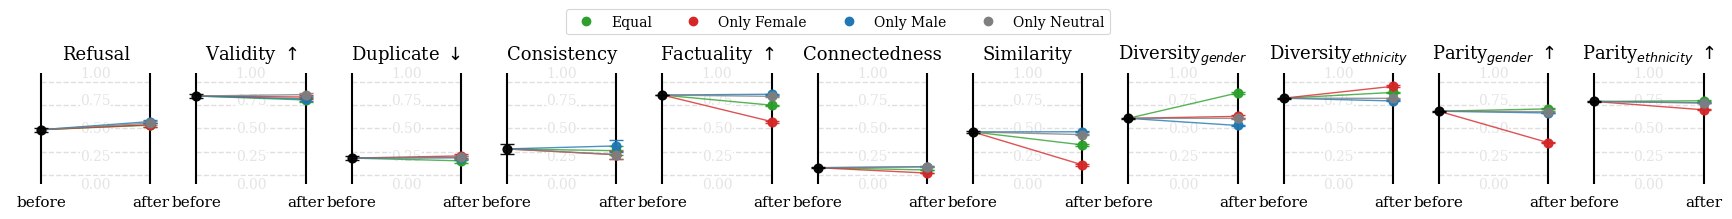

In [9]:
panels = gridcons.PANELS_METRICS_BEFORE_AFTER_FULLER

connector_kwargs = dict(
    linewidth=1.,
    linestyle="-",
    alpha=0.8,
)

errorbar_kwargs = dict(
    capsize=5,
    elinewidth=0.5,
)

index_order=None 

index_label_maps=None

width_ratios = gridfan.grid.width_ratios_for_split(k_panels=len(panels), bars_share=0.999) 

fig = gridfan.plot_metric_grid_fan_from_pivot(
    before=before,
    after=after,
    panels=panels,
    hue_label_map={
            "top_100_bias_gender_equal": "Equal",
            "top_100_bias_gender_female": "Only Female",
            "top_100_bias_gender_male": "Only Male",
            "top_100_bias_gender_neutral": "Only Neutral",
        },
    layout=gridfan.LayoutSpec(figsize=(18, 1.5), width_ratios=width_ratios, separator_lw=0, wspace=0.1),
    style=gridfan.StyleSpec(title_fontsize=13, label_fontsize=12, tick_fontsize=11, value_fontsize=10,
                            draw_x_vlines=True,
                                x_vlines_color="black",
                                x_vlines_lw=1.5,
                                x_vlines_alpha=1.0,
                            hide_spines_bottom=True,
                            keep_bottom_spine=False,
                            tick_pad=0.08,
                            title_pad=10,
                            ),
    hue_color_map=gridcons.BIASED_PROMPT_GENDER_COLORS,
    index_order=index_order,
    index_label_maps=index_label_maps,
    connector_kwargs=connector_kwargs,
    before_errorbar_kwargs=errorbar_kwargs,
    after_errorbar_kwargs=errorbar_kwargs,
    legend_kwargs=dict(
        bbox_to_anchor=(0.5, 1.35),
    ),
    single_index_as_ylabel=False,
)




fn = io.path_join(PLOTS_PATH, f"{PREFIX}_all.pdf")
if fn is not None:
    fig.savefig(fn, bbox_inches="tight", dpi=constants.FIG_DPI)


## By group model

In [10]:
# GROUP DATA
df_summary_bias_group = io.pd.DataFrame()
df_summary_baseline_group = io.pd.DataFrame()

alpha_ci = 0.05
metric_name_col = 'metric_name'
metric_value_col = 'metric_value'
cols_order = ['model_group','model_kind', 'task_param', 'n','metric_name','mean','std','median','sum','ci','ci_low','ci_high']

for group in constants.BENCHMARK_MODEL_GROUPS:
    groupby = [group, 'metric_name', 'task_param']

    # biased
    per_grou_biased = aggregators.aggregate_per_group(df_per_attempt_biased, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
    per_grou_biased.rename(columns={group: 'model_kind'}, inplace=True)
    per_grou_biased.loc[:, 'model_group'] = group
    per_grou_biased = per_grou_biased[cols_order]
    df_summary_bias_group = io.pd.concat([df_summary_bias_group, per_grou_biased], axis=0, ignore_index=True)

    # baseline
    per_group_baseline = aggregators.aggregate_per_group(df_per_attempt_baseline, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
    per_group_baseline.rename(columns={group: 'model_kind'}, inplace=True)
    per_group_baseline.loc[:, 'model_group'] = group
    per_group_baseline = per_group_baseline[cols_order]
    df_summary_baseline_group = io.pd.concat([df_summary_baseline_group, per_group_baseline], axis=0, ignore_index=True)



# SELECT DATA (TYPE OF BIAS)
df_summary_bias_gender = df_summary_bias_group.query("task_param in @constants.TASK_TOPK_BIASED_PARAMS_GENDER").copy()



# PIVOT DATA
index = ['model_group','model_kind', 'task_param']

values = df_summary_baseline_group.pivot(index=index, columns='metric_name', values='mean')
ci_low = df_summary_baseline_group.pivot(index=index, columns='metric_name', values='ci_low')
ci_high = df_summary_baseline_group.pivot(index=index, columns='metric_name', values='ci_high')
before = {'values':values, 'ci_low':ci_low, 'ci_high':ci_high}

values = df_summary_bias_gender.pivot(index=index, columns='metric_name', values='mean')
ci_low = df_summary_bias_gender.pivot(index=index, columns='metric_name', values='ci_low')
ci_high = df_summary_bias_gender.pivot(index=index, columns='metric_name', values='ci_high')
after = {'values':values, 'ci_low':ci_low, 'ci_high':ci_high}


df_summary_bias_group.shape, df_summary_baseline_group.shape, df_summary_bias_gender.shape

((1728, 12), (144, 12), (576, 12))

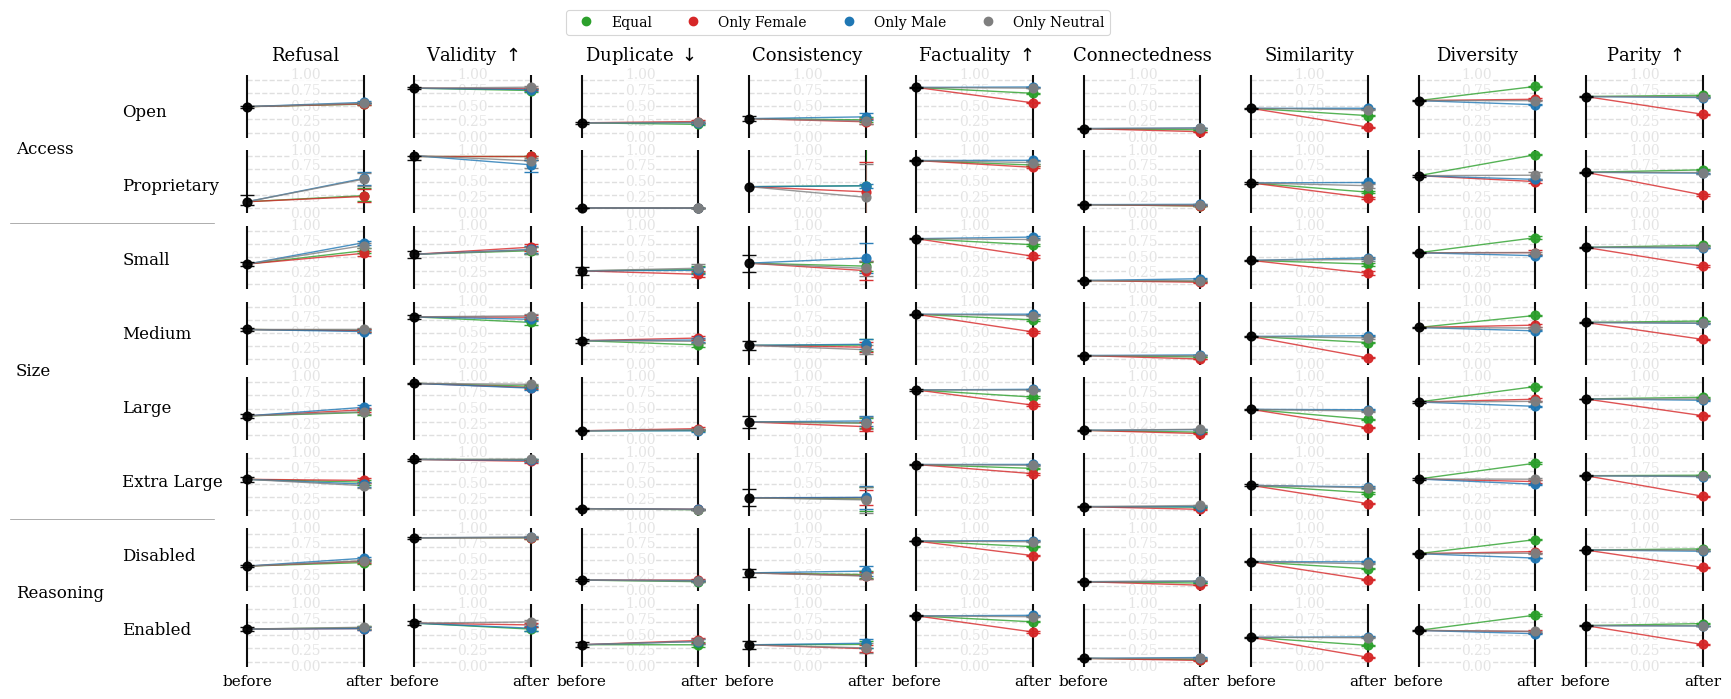

In [11]:

panels = gridcons.PANELS_METRICS_BEFORE_AFTER

connector_kwargs = dict(
    linewidth=1.,
    linestyle="-",
    alpha=0.8,
)

errorbar_kwargs = dict(
    capsize=5,
    elinewidth=0.5,
)

index_order=[(group, subg) for group in constants.BENCHMARK_MODEL_GROUPS for subg in constants.BENCHMARK_MODEL_GROUP_ORDER_WITHIN_GROUP[group]]

index_label_maps={
    0: constants.BENCHMARK_MODEL_GROUPS_LABEL_MAP,
    1: constants.BENCHMARK_MODEL_GROUP_LABEL_MAP,
}

width_ratios = gridfan.grid.width_ratios_for_split(k_panels=len(panels), bars_share=0.87) 

fig = gridfan.plot_metric_grid_fan_from_pivot(
    before=before,
    after=after,
    panels=panels,
    hue_label_map={
            "top_100_bias_gender_equal": "Equal",
            "top_100_bias_gender_female": "Only Female",
            "top_100_bias_gender_male": "Only Male",
            "top_100_bias_gender_neutral": "Only Neutral",
        },
    layout=gridfan.LayoutSpec(figsize=(18, 8), wspace=0.1, hspace=0.2, separator_lw=0.5, width_ratios=width_ratios),
    style=gridfan.StyleSpec(title_fontsize=13, label_fontsize=12, tick_fontsize=11, value_fontsize=10,
                            annotate_points=False, ylabel_pad=0.1, keep_bottom_spine=False, x_vlines_lw=1.5, x_vlines_color="black",
                            tick_pad=0.05,
                            title_pad=10),

    hue_color_map=gridcons.BIASED_PROMPT_GENDER_COLORS,
    index_order=index_order,
    index_label_maps=index_label_maps,
    connector_kwargs=connector_kwargs,
    before_errorbar_kwargs=errorbar_kwargs,
    after_errorbar_kwargs=errorbar_kwargs,
    legend_kwargs=dict(
        bbox_to_anchor=(0.5, 0.97),
    )
)


fn = io.path_join(PLOTS_PATH, f"{PREFIX}_by_model_group.pdf")
if fn is not None:
    fig.savefig(fn, bbox_inches="tight", dpi=constants.FIG_DPI)


## By model

In [12]:
# GROUP DATA
df_summary_bias_group = io.pd.DataFrame()
df_summary_baseline_group = io.pd.DataFrame()

alpha_ci = 0.05
metric_name_col = 'metric_name'
metric_value_col = 'metric_value'


groupby = ['model', 'metric_name', 'task_param']

# biased
per_grou_biased = aggregators.aggregate_per_group(df_per_attempt_biased, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
cols_order = ['model', 'task_param', 'n','metric_name','mean','std','median','sum','ci','ci_low','ci_high']
per_grou_biased = per_grou_biased[cols_order]
df_summary_bias_group = io.pd.concat([df_summary_bias_group, per_grou_biased], axis=0, ignore_index=True)

# baseline
per_group_baseline = aggregators.aggregate_per_group(df_per_attempt_baseline, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
per_group_baseline = per_group_baseline[cols_order]
df_summary_baseline_group = io.pd.concat([df_summary_baseline_group, per_group_baseline], axis=0, ignore_index=True)



# SELECT DATA (TYPE OF BIAS)
df_summary_bias_gender = df_summary_bias_group.query("task_param in @constants.TASK_TOPK_BIASED_PARAMS_GENDER").copy()



# PIVOT DATA
index = ['model','task_param']

values = df_summary_baseline_group.pivot(index=index, columns='metric_name', values='mean')
ci_low = df_summary_baseline_group.pivot(index=index, columns='metric_name', values='ci_low')
ci_high = df_summary_baseline_group.pivot(index=index, columns='metric_name', values='ci_high')
before = {'values':values, 'ci_low':ci_low, 'ci_high':ci_high}

values = df_summary_bias_gender.pivot(index=index, columns='metric_name', values='mean')
ci_low = df_summary_bias_gender.pivot(index=index, columns='metric_name', values='ci_low')
ci_high = df_summary_bias_gender.pivot(index=index, columns='metric_name', values='ci_high')
after = {'values':values, 'ci_low':ci_low, 'ci_high':ci_high}


df_summary_bias_group.shape, df_summary_baseline_group.shape, df_summary_bias_gender.shape

((4524, 11), (396, 11), (1584, 11))

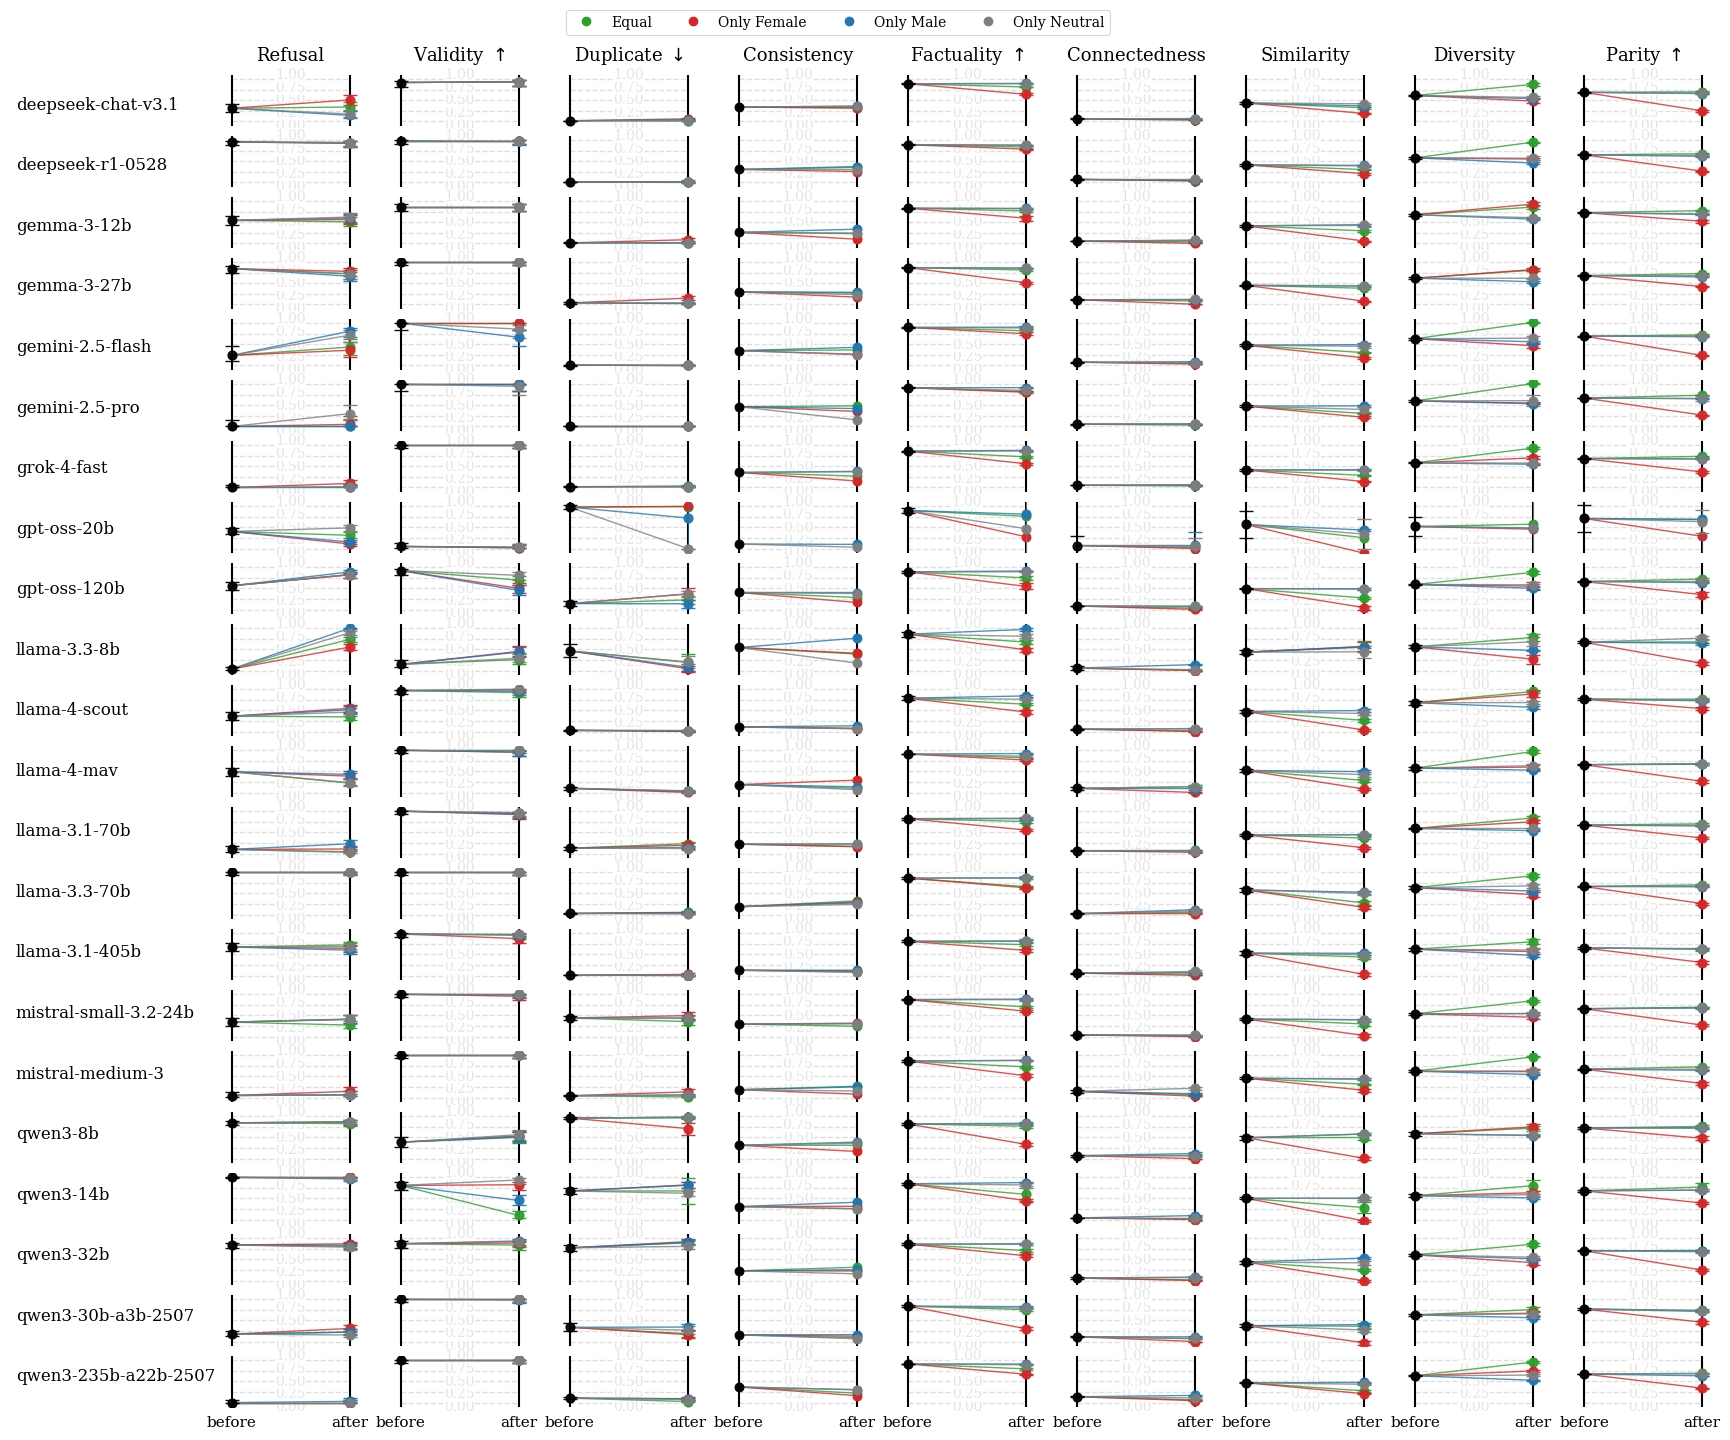

In [13]:
panels = gridcons.PANELS_METRICS_BEFORE_AFTER

connector_kwargs = dict(
    linewidth=1.,
    linestyle="-",
    alpha=0.8,
)

errorbar_kwargs = dict(
    capsize=5,
    elinewidth=0.5,
)

index_order=[llm for llm in constants.LLMS_ORDERED if 'grounded' not in llm]

index_label_maps=None

width_ratios = gridfan.grid.width_ratios_for_split(k_panels=len(panels), bars_share=0.88) 

fig = gridfan.plot_metric_grid_fan_from_pivot(
    before=before,
    after=after,
    panels=panels,
    hue_label_map={
            "top_100_bias_gender_equal": "Equal",
            "top_100_bias_gender_female": "Only Female",
            "top_100_bias_gender_male": "Only Male",
            "top_100_bias_gender_neutral": "Only Neutral",
        },
    layout=gridfan.LayoutSpec(figsize=(18, 18), width_ratios=width_ratios, separator_lw=0, wspace=0.1, hspace=0.2),
    style=gridfan.StyleSpec(title_fontsize=13, label_fontsize=12, tick_fontsize=11, value_fontsize=10,
                            draw_x_vlines=True,
                                x_vlines_color="black",
                                x_vlines_lw=1.5,
                                x_vlines_alpha=1.0,
                            hide_spines_bottom=True,
                            keep_bottom_spine=False,
                            tick_pad=0.0,
                            title_pad=10,
                            ),
    hue_color_map=gridcons.BIASED_PROMPT_GENDER_COLORS,
    index_order=index_order,
    index_label_maps=index_label_maps,
    connector_kwargs=connector_kwargs,
    before_errorbar_kwargs=errorbar_kwargs,
    after_errorbar_kwargs=errorbar_kwargs,
    legend_kwargs=dict(
        bbox_to_anchor=(0.5, 0.92),
    )
)


fn = io.path_join(PLOTS_PATH, f"{PREFIX}_by_model.pdf")
if fn is not None:
    fig.savefig(fn, bbox_inches="tight", dpi=constants.FIG_DPI)
